# Pytorch构建神经网络(四)（网站35-39）

## 35-Pytorch on the GPU - Training NN with CUDA
## 使用GPU训练NN

### 1. 如何使用GPU？

In [1]:
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision 
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from IPython.display import display,clear_output
import pandas as pd 
import time
import json

from itertools import product
from collections import namedtuple
from collections import OrderedDict


In [2]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        
        self.fc1 = nn.Linear(in_features=12*4*4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)
    
    def forward(self, t):
        t = t 
        t = F.relu(self.conv1(t))
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        
        t = F.relu(self.conv2(t))
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        
        t = t.flatten(start_dim=1)
        t = F.relu(self.fc1(t))
        t = F.relu(self.fc2(t))
        t = self.out(t)
        
        return t

In [3]:
class RunBuilder():
    @staticmethod
    def get_runs(params): # 通过指定类并指定方法来调用
        Run = namedtuple('Run', params.keys())
        runs = []
        for v in product(*params.values()):
            runs.append(Run(*v))
        return runs

In [5]:
# begin_epoch 和 end_epoch允许我们在整个生命周期中管理这些值
class RunManager():
    # 构造函数
    def __init__(self):
        # 相同前缀的数据可以考虑用类来整合
        '''
        class Epoch():
            def __init__(self):
                self.count = 0
                self.loss = 0
                self.num_correct = 0
                self.start_time = None 
                
        e = Epoch()
        e.count
        '''
        self.epoch_count = 0 # 追踪周期的数量
        self.epoch_loss = 0 # 损失的运行周期
        self.epoch_num_correct = 0 # 正确预测数的周期
        self.epoch_start_time = None # 开始时间的周期
        
        self.run_params = None # 运行参数
        self.run_count = 0 # 运行计数
        self.run_data = [] # 运行数据 每个周期的参数值和结果
        self.run_start_time = None # 运行开始时间 计算运行时间
        
        self.network = None # 运行网络
        self.loader = None # 数据加载器
        self.tb = None # summary writer=》tensorboard
        
    # 提取开始运行所需的相关东西
    def begin_run(self, run, network, loader):
        self.run_start_time = time.time() # 获取运行的开始时间
        
        self.run_params = run
        self.run_count += 1
        
        self.network = network
        self.loader = loader
        self.tb = SummaryWriter(comment=f'-{run}') # 作为通用参数传入
        
        images, labels = next(iter(self.loader))
        grid = torchvision.utils.make_grid(images)
        
        self.tb.add_image('images', grid)
        self.tb.add_graph(self.network, images)
        
    # 本次运行结束 关闭tensorboard 并 将周期数重新设置为0
    def end_run(self):
        self.tb.close()
        self.epoch_count = 0
        
    # 每次周期开始
    def begin_epoch(self):
        self.epoch_start_time = time.time() # 本次周期开始时间
        
        # 本次周期内的变量
        self.epoch_count += 1
        self.epoch_loss = 0
        self.epoch_num_correct = 0
    
    # 周期结束
    def end_epoch(self):
        epoch_duration = time.time() - self.epoch_start_time # 周期市场
        run_duration = time.time() - self.run_start_time # 本次运行时长
        
        loss = self.epoch_loss/len(self.loader.dataset) # 计算损失
        accuracy = self.epoch_num_correct/len(self.loader.dataset) # 计算准确率
        
        # 将变量加入tensorboard
        self.tb.add_scalar('Loss', loss, self.epoch_count)
        self.tb.add_scalar('Accuracy', accuracy, self.epoch_count)
        
        # 将直方图加入tensorboard
        for name, param in self.network.named_parameters():
            self.tb.add_histogram(name, param, self.epoch_count)
            self.tb.add_histogram(f'{name}.grad', param.grad, self.epoch_count)
            
        # 周期内的相关结果记录
        results = OrderedDict()
        results["run"] = self.run_count
        results["epoch"] = self.epoch_count
        results["loss"] = loss
        results["accuracy"] = accuracy
        results["epoch duration"] = epoch_duration
        results["run duration"] = run_duration
        # 运行参数
        for k,v in self.run_params._asdict().items(): results[k] = v
        self.run_data.append(results)
        df = pd.DataFrame.from_dict(self.run_data, orient='columns')

        # 关于jupyter notebook的=》清除当前的输出并显示一个新的数据帧
        clear_output(wait=True)
        display(df)
    
    def track_loss(self, loss):
        self.epoch_loss += loss.item()*self.loader.batch_size
    
    def track_num_correct(self, preds, labels):
        self.epoch_num_correct += self._get_num_correct(preds, labels)
    
    @torch.no_grad()
    def _get_num_correct(self, preds, labels):
        return preds.argmax(dim=1).eq(labels).sum().item()
    
    # 保存为json或者csv
    def save(self, fileName):
        pd.DataFrame.from_dict(
            self.run_data,
            orient='columns').to_csv(f'{fileName}.csv')
        with open(f'{fileName}.json','w', encoding='utf-8') as f:
            json.dump(self.run_data, f, ensure_ascii=False, indent=4)

In [6]:
train_set = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
)

In [ ]:
# 使用RunManager和RunBuilder类可以使得程序更简单、更易扩展、更容易推理
from  torch.utils.data import DataLoader
import time
import pandas as pd
from easydl import clear_output

params = OrderedDict(
    lr = [.01],
    batch_size =[1000, 2000],
    shuffle = [True, False]
)
m = RunManager()
for run in RunBuilder.get_runs(params):
    
    network = Network()
    loader = DataLoader(train_set, batch_size=run.batch_size, shuffle=run.shuffle)
    optimizer = optim.Adam(network.parameters(), lr=run.lr)
    
    m.begin_run(run, network, loader)
    for epoch in range(5):
        m.begin_epoch()
        for batch in loader:
            #images, labels = batch
            images = batch[0]
            labels = batch[1]
            preds = network(images)
            loss = F.cross_entropy(preds, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            m.track_loss(loss)
            m.track_num_correct(preds, labels)
            
        m.end_epoch()
    m.end_run()
m.save('resuls')

### 移动到GPU

In [7]:
t = torch.ones(1,1,28,28)
network = Network()

In [8]:
# 把张量移动到GPU上
t = t.cuda()
network = network.cuda()

In [9]:
# 把张量传给网络 得到预测
gpu_pred = network(t)
gpu_pred.device

device(type='cuda', index=0)

### 移动到CPU上

In [10]:
t = t.cpu()
network = network.cpu()

In [11]:
cpu_pred = network(t)
cpu_pred.device

device(type='cpu')

需要确保数据：张量和网络在同一设备上

In [12]:
t1 = torch.tensor([
    [1,2],
    [3,4]
])

t2 = torch.tensor([
    [5,6],
    [7,8]
])

In [13]:
t1.device, t2.device

(device(type='cpu'), device(type='cpu'))

In [14]:
t1 = t1.to('cuda')
t1.device

device(type='cuda', index=0)

In [15]:
try: 
    t1 + t2
except Exception as e:
    print(e)

Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!


In [16]:
try: 
    t2 + t1
except Exception as e: 
    print(e)

Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!


新版报错中已经没有了变化

In [17]:
# .to()方法也可以变换设备 传入的参数是将要移动到的设备
# 在设备上移动张量时首选.to()方法
t2 = t2.to('cuda')
t1 + t2

tensor([[ 6,  8],
        [10, 12]], device='cuda:0')

pytorch支持多个gpu，默认index为0

### 将NN模块移动

In [18]:
network = Network()

In [19]:
for name, param in network.named_parameters():
    print(name, '\t\t', param.shape)

conv1.weight 		 torch.Size([6, 1, 5, 5])
conv1.bias 		 torch.Size([6])
conv2.weight 		 torch.Size([12, 6, 5, 5])
conv2.bias 		 torch.Size([12])
fc1.weight 		 torch.Size([120, 192])
fc1.bias 		 torch.Size([120])
fc2.weight 		 torch.Size([60, 120])
fc2.bias 		 torch.Size([60])
out.weight 		 torch.Size([10, 60])
out.bias 		 torch.Size([10])


In [20]:
for n, p in network.named_parameters():
    print(p.device, '', n)

cpu  conv1.weight
cpu  conv1.bias
cpu  conv2.weight
cpu  conv2.bias
cpu  fc1.weight
cpu  fc1.bias
cpu  fc2.weight
cpu  fc2.bias
cpu  out.weight
cpu  out.bias


In [21]:
# 将网络移动到cuda
network.to('cuda')

Network(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=192, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=10, bias=True)
)

In [22]:
for n, p in network.named_parameters():
    print(p.device, '', n)

cuda:0  conv1.weight
cuda:0  conv1.bias
cuda:0  conv2.weight
cuda:0  conv2.bias
cuda:0  fc1.weight
cuda:0  fc1.bias
cuda:0  fc2.weight
cuda:0  fc2.bias
cuda:0  out.weight
cuda:0  out.bias


In [23]:
sample = torch.ones(1,1,28,28)
sample.shape

torch.Size([1, 1, 28, 28])

In [24]:
try:
    network(sample)
except Exception as e: 
    print(e)

Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same


In [25]:
try:
    pred = network(sample.to('cuda'))
    print(pred)
except Exception as e:
    print(e)

tensor([[ 0.0890, -0.1137, -0.0182, -0.0755,  0.0545,  0.0539,  0.0192, -0.0784,
         -0.0724,  0.0929]], device='cuda:0', grad_fn=<AddmmBackward>)


### 检查GPU相关及测试

In [26]:
torch.cuda.is_available()

True

In [27]:
# begin_epoch 和 end_epoch允许我们在整个生命周期中管理这些值
class RunManager():
    # 构造函数
    def __init__(self):
        # 相同前缀的数据可以考虑用类来整合
        '''
        class Epoch():
            def __init__(self):
                self.count = 0
                self.loss = 0
                self.num_correct = 0
                self.start_time = None 
                
        e = Epoch()
        e.count
        '''
        self.epoch_count = 0 # 追踪周期的数量
        self.epoch_loss = 0 # 损失的运行周期
        self.epoch_num_correct = 0 # 正确预测数的周期
        self.epoch_start_time = None # 开始时间的周期
        
        self.run_params = None # 运行参数
        self.run_count = 0 # 运行计数
        self.run_data = [] # 运行数据 每个周期的参数值和结果
        self.run_start_time = None # 运行开始时间 计算运行时间
        
        self.network = None # 运行网络
        self.loader = None # 数据加载器
        self.tb = None # summary writer=》tensorboard
        
    # 提取开始运行所需的相关东西
    def begin_run(self, run, network, loader):
        self.run_start_time = time.time() # 获取运行的开始时间
        
        self.run_params = run
        self.run_count += 1
        
        self.network = network
        self.loader = loader
        self.tb = SummaryWriter(comment=f'-{run}') # 作为通用参数传入
        
        images, labels = next(iter(self.loader))
        grid = torchvision.utils.make_grid(images)
        
        self.tb.add_image('images', grid)
        # 向后兼容我们已经写过的
        self.tb.add_graph( 
            self.network, 
            images.to(getattr(run, 'device', 'cpu'))
        )
        
    # 本次运行结束 关闭tensorboard 并 将周期数重新设置为0
    def end_run(self):
        self.tb.close()
        self.epoch_count = 0
        
    # 每次周期开始
    def begin_epoch(self):
        self.epoch_start_time = time.time() # 本次周期开始时间
        
        # 本次周期内的变量
        self.epoch_count += 1
        self.epoch_loss = 0
        self.epoch_num_correct = 0
    
    # 周期结束
    def end_epoch(self):
        epoch_duration = time.time() - self.epoch_start_time # 周期市场
        run_duration = time.time() - self.run_start_time # 本次运行时长
        
        loss = self.epoch_loss/len(self.loader.dataset) # 计算损失
        accuracy = self.epoch_num_correct/len(self.loader.dataset) # 计算准确率
        
        # 将变量加入tensorboard
        self.tb.add_scalar('Loss', loss, self.epoch_count)
        self.tb.add_scalar('Accuracy', accuracy, self.epoch_count)
        
        # 将直方图加入tensorboard
        for name, param in self.network.named_parameters():
            self.tb.add_histogram(name, param, self.epoch_count)
            self.tb.add_histogram(f'{name}.grad', param.grad, self.epoch_count)
            
        # 周期内的相关结果记录
        results = OrderedDict()
        results["run"] = self.run_count
        results["epoch"] = self.epoch_count
        results["loss"] = loss
        results["accuracy"] = accuracy
        results["epoch duration"] = epoch_duration
        results["run duration"] = run_duration
        # 运行参数
        for k,v in self.run_params._asdict().items(): results[k] = v
        self.run_data.append(results)
        df = pd.DataFrame.from_dict(self.run_data, orient='columns')

        # 关于jupyter notebook的=》清除当前的输出并显示一个新的数据帧
        clear_output(wait=True)
        display(df)
    
    def track_loss(self, loss):
        self.epoch_loss += loss.item()*self.loader.batch_size
    
    def track_num_correct(self, preds, labels):
        self.epoch_num_correct += self._get_num_correct(preds, labels)
    
    @torch.no_grad()
    def _get_num_correct(self, preds, labels):
        return preds.argmax(dim=1).eq(labels).sum().item()
    
    # 保存为json或者csv
    def save(self, fileName):
        pd.DataFrame.from_dict(
            self.run_data,
            orient='columns').to_csv(f'{fileName}.csv')
        with open(f'{fileName}.json','w', encoding='utf-8') as f:
            json.dump(self.run_data, f, ensure_ascii=False, indent=4)

In [29]:
params = OrderedDict(
    lr = [.01],
    batch_size =[1000, 10000,20000],
    num_workers = [0,1],
    device = ['cuda','cpu']
)
m = RunManager()
for run in RunBuilder.get_runs(params):
    
    device = torch.device(run.device) # 获取当前运行设备
    network = Network().to(device) # 移动至相应设备
    loader = DataLoader(train_set, batch_size=run.batch_size, num_workers = run.num_workers)
    optimizer = optim.Adam(network.parameters(), lr=run.lr)
    
    m.begin_run(run, network, loader)
    for epoch in range(1):
        m.begin_epoch()
        for batch in loader:
            #images, labels = batch
            images = batch[0].to(device)
            labels = batch[1].to(device)
            preds = network(images)
            loss = F.cross_entropy(preds, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            m.track_loss(loss)
            m.track_num_correct(preds, labels)
            
        m.end_epoch()
    m.end_run()
m.save('resuls')

,run,epoch,loss,accuracy,epoch duration,run duration,lr,batch_size,num_workers,device
0,1,1,0.912399,0.647350,13.462852,14.671617,0.01,1000,0,cuda
1,2,1,1.088801,0.575317,22.311960,24.039187,0.01,1000,0,cpu
2,3,1,0.997120,0.618533,10.995577,14.081319,0.01,1000,1,cuda
3,4,1,1.021087,0.611217,13.822472,17.319114,0.01,1000,1,cpu
4,5,1,2.139705,0.269483,12.998218,19.689312,0.01,10000,0,cuda
5,6,1,2.114025,0.260183,19.542706,29.198867,0.01,10000,0,cpu
6,7,1,2.105096,0.300283,10.857934,19.965589,0.01,10000,1,cuda
7,8,1,2.184289,0.185033,14.848268,27.075549,0.01,10000,1,cpu


RuntimeError: CUDA out of memory. Tried to allocate 264.00 MiB (GPU 0; 2.00 GiB total capacity; 787.36 MiB already allocated; 259.20 MiB free; 862.00 MiB reserved in total by PyTorch)

In [30]:
pd.DataFrame.from_dict(m.run_data, orient='columns').sort_values('epoch duration')

,run,epoch,loss,accuracy,epoch duration,run duration,lr,batch_size,num_workers,device
6,7,1,2.105096,0.300283,10.857934,19.965589,0.01,10000,1,cuda
2,3,1,0.997120,0.618533,10.995577,14.081319,0.01,1000,1,cuda
4,5,1,2.139705,0.269483,12.998218,19.689312,0.01,10000,0,cuda
0,1,1,0.912399,0.647350,13.462852,14.671617,0.01,1000,0,cuda
3,4,1,1.021087,0.611217,13.822472,17.319114,0.01,1000,1,cpu
7,8,1,2.184289,0.185033,14.848268,27.075549,0.01,10000,1,cpu
5,6,1,2.114025,0.260183,19.542706,29.198867,0.01,10000,0,cpu
1,2,1,1.088801,0.575317,22.311960,24.039187,0.01,1000,0,cpu


## 36-NN Programming -learning with pytorvch
## pytorch dataset normalization
## 归一化

### 数据归一化
- 将数据集中的每个样本转换为一组新的值的行为
- 具有数据的缩放特征=》特征缩放（指当我们对数据或者数据集进行归一化时，我们经常将该数据集的各种特征归一化到相同的尺度）
- 我们考虑的时具有多个特征和相关值的样本或元素的数据集
- 新归一化的数据集中的数据点通常对相对于整个数据集的信息进行编码和类型划分
- 重点：缩放区间
- 我们之所以能知道归一化集合中的最大值，是因为这些信息被编码成了归一化集合中的新值

### 标准化 Standardization
- 重点：平均值mean和标准差std实现（计算必须是针对某个特定的特征/通道）
- 是一种特殊类型的归一化技术
- z score  z =(x-mean)/std
- 归一化和标准化的区别？
    - 归一化 是一个一般的过程，归一化数据集有许多不同的方法
    - 标准化是一个更具体的过程，是归一化的一种更具体的方法

In [37]:
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision 
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [38]:
train_set = torchvision.datasets.FashionMNIST(
    root='./data'
    ,train=True
    ,download=True
    ,transform=transforms.Compose([
        transforms.ToTensor()
        # normalize
    ])
)

#### 一种简单的方法
把整个数据集加载到内存中，然后以张量的形式得到数据集

In [39]:
loader = DataLoader(train_set, batch_size=len(train_set), num_workers=1)
data = next(iter(loader))
data[0].mean(), data[0].std()

(tensor(0.2860), tensor(0.3530))

#### 一种较为难的方法
迭代许多批数据，因为如果数据集太大，无法装入内存，就必须这样

即，分解成单独的批，然后迭代

In [34]:
loader = DataLoader(train_set, batch_size=1000, num_workers=1)
num_of_pixels = len(train_set) * 28 * 28

total_sum = 0
for batch in loader: 
    total_sum += batch[0].sum()
mean = total_sum / num_of_pixels

sum_of_squared_error = 0
for batch in loader: 
    sum_of_squared_error += ((batch[0] - mean).pow(2)).sum()
std = torch.sqrt(sum_of_squared_error / num_of_pixels)

mean,std

(tensor(0.2860), tensor(0.3530))

In [ ]:
# 将这些值画成柱状图
# 本机无法执行 内存爆掉
plt.hist(data[0].flatten())
plt.axvline(data[0].mean())

#### 直接使用std和mean处理后的值

In [43]:
train_set_normal = torchvision.datasets.FashionMNIST(
    root='./data'
    ,train=True
    ,download=True
    ,transform=transforms.Compose([
        transforms.ToTensor(), 
        #transforms.Normalize(mean, std)
        # pytorch版本导致的
        transforms.Normalize((mean,), (std,))
    ])
)

In [44]:
# 继续对归一化后的数据上计算mean和std
loader = DataLoader(
      train_set_normal
    , batch_size=len(train_set)
    , num_workers=1
)
data = next(iter(loader))
data[0].mean(), data[0].std()

(tensor(-9.3670e-08), tensor(1.))

In [ ]:
plt.hist(data[0].flatten())

In [ ]:
# 对之前的NN模块进行改进的话
trainsets = {
    'not_normal': train_set
    ,'normal': train_set_normal
}

In [ ]:
params = OrderedDict(
      lr = [.01]
    , batch_size = [1000]
    , num_workers = [1]
    , device = ['cuda']
    , trainset = ['not_normal', 'normal']
)
m = RunManager()
for run in RunBuilder.get_runs(params):

    device = torch.device(run.device)
    network = Network().to(device)
    loader = DataLoader(
          trainsets[run.trainset]
        , batch_size=run.batch_size
        , num_workers=run.num_workers
    )
    optimizer = optim.Adam(network.parameters(), lr=run.lr)

    m.begin_run(run, network, loader)
    for epoch in range(20):
        m.begin_epoch()
        for batch in loader:

            images = batch[0].to(device)
            labels = batch[1].to(device)
            preds = network(images) # Pass Batch
            loss = F.cross_entropy(preds, labels) # Calculate Loss
            optimizer.zero_grad() # Zero Gradients
            loss.backward() # Calculate Gradients
            optimizer.step() # Update Weights

            m.track_loss(loss, batch)
            m.track_num_correct(preds, labels)
        m.end_epoch()
    m.end_run()
m.save('results')

In [ ]:
# 根据精确度降序排序=》normal的dataset会更高的精度
pd.DataFrame.from_dict(m.run_data).sort_values('accuracy', ascending=False)

- 归一化数据并不总是正确的
- 是否归一化数据，可以尝试归一化和非归一化的对比
- 批量归一化：除了不是在训练数据或数据集上进行之外，过程是一样的

## 37-Pytorch DataLoader Source Code 
## Debugging Session

## 38-Pytorch Sequential Models
## 让NN模型更加简单

好处：
- 快速建立NN模型
- 调过需要完善的部分（因为顺序模型直接帮我们完善好了）
- 我们可以把很多NN模型包装成一个顺序模型
- pytorch已经把那些特殊的功能性函数包装在一个NN模块内部

有三种方法创建一个顺序模型

In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import math

from collections import OrderedDict

torch.set_printoptions(linewidth=150)

In [47]:
train_set = torchvision.datasets.FashionMNIST(
    root='./data'
    ,train=True
    ,download=True
    ,transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

In [48]:
image, label = train_set[0]
image.shape

torch.Size([1, 28, 28])

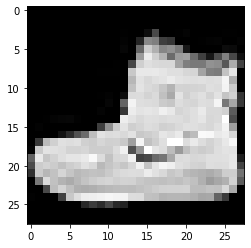

In [49]:
plt.imshow(image.squeeze(),cmap='gray')

In [51]:
train_set.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [52]:
in_features = image.numel()
in_features

784

In [53]:
out_features = math.floor(in_features / 2)
out_features

392

In [54]:
out_classes = len(train_set.classes)
out_classes

10

### 方法一

In [55]:
network1 = nn.Sequential(
    nn.Flatten(start_dim=1)
    ,nn.Linear(in_features, out_features)
    ,nn.Linear(out_features, out_classes)
)

In [56]:
network1

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=392, bias=True)
  (2): Linear(in_features=392, out_features=10, bias=True)
)

In [57]:
network1[1]

Linear(in_features=784, out_features=392, bias=True)

In [58]:
image = image.unsqueeze(0) # 多一个batch=1
image.shape

torch.Size([1, 1, 28, 28])

In [59]:
network1(image)
# 这些结果并不准确 因为没有经过训练

tensor([[-0.2349, -0.0368, -0.0631, -0.1978,  0.0207, -0.3592,  0.0143, -0.0159, -0.1418, -0.0601]], grad_fn=<AddmmBackward>)

### 方法二

In [60]:
layers = OrderedDict([
    ('flat', nn.Flatten(start_dim=1))
   ,('hidden', nn.Linear(in_features, out_features))
   ,('output', nn.Linear(out_features, out_classes))
])

network2 = nn.Sequential(layers)
network2

Sequential(
  (flat): Flatten(start_dim=1, end_dim=-1)
  (hidden): Linear(in_features=784, out_features=392, bias=True)
  (output): Linear(in_features=392, out_features=10, bias=True)
)

In [61]:
network2(image)
# 结果不一样是因为权重设置不一样

tensor([[ 0.1273,  0.0579, -0.0540, -0.2217, -0.2490, -0.0698, -0.0576, -0.0817,  0.0307, -0.3328]], grad_fn=<AddmmBackward>)

In [62]:
# 如果想让结果一样 设置seed
torch.manual_seed(50)
network1 = nn.Sequential(
    nn.Flatten(start_dim=1)
    ,nn.Linear(in_features, out_features)
    ,nn.Linear(out_features, out_classes)
)

torch.manual_seed(50)
layers = OrderedDict([
    ('flat', nn.Flatten(start_dim=1))
   ,('hidden', nn.Linear(in_features, out_features))
   ,('output', nn.Linear(out_features, out_classes))
])

network2 = nn.Sequential(layers)

In [63]:
network1(image),network2(image)

(tensor([[ 0.1681,  0.1028, -0.0790, -0.0659, -0.2436,  0.1328, -0.0864,  0.0016,  0.1819, -0.0168]], grad_fn=<AddmmBackward>),
 tensor([[ 0.1681,  0.1028, -0.0790, -0.0659, -0.2436,  0.1328, -0.0864,  0.0016,  0.1819, -0.0168]], grad_fn=<AddmmBackward>))

### 方法三

In [64]:
torch.manual_seed(50)
network3 = nn.Sequential()
network3.add_module('flat', nn.Flatten(start_dim=1))
network3.add_module('hidden', nn.Linear(in_features, out_features))
network3.add_module('output', nn.Linear(out_features, out_classes))
network3

Sequential(
  (flat): Flatten(start_dim=1, end_dim=-1)
  (hidden): Linear(in_features=784, out_features=392, bias=True)
  (output): Linear(in_features=392, out_features=10, bias=True)
)

In [65]:
network1(image),network2(image),network3(image)

(tensor([[ 0.1681,  0.1028, -0.0790, -0.0659, -0.2436,  0.1328, -0.0864,  0.0016,  0.1819, -0.0168]], grad_fn=<AddmmBackward>),
 tensor([[ 0.1681,  0.1028, -0.0790, -0.0659, -0.2436,  0.1328, -0.0864,  0.0016,  0.1819, -0.0168]], grad_fn=<AddmmBackward>),
 tensor([[ 0.1681,  0.1028, -0.0790, -0.0659, -0.2436,  0.1328, -0.0864,  0.0016,  0.1819, -0.0168]], grad_fn=<AddmmBackward>))

### 之前的class定义法和现在的顺序模型对比

In [66]:
# 类定义
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 12, 5)

        self.fc1 = nn.Linear(in_features=12*4*4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)

    def forward(self, t):

        t = F.relu(self.conv1(t))
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        t = F.relu(self.conv2(t))
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        t = t.flatten(start_dim=1)
        t = F.relu(self.fc1(t))
        t = F.relu(self.fc2(t))
        t = self.out(t)

        return t

In [67]:
network = Network()

In [68]:
# 顺序模型
sequential = nn.Sequential(
      nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
    , nn.ReLU()
    , nn.MaxPool2d(kernel_size=2, stride=2)
    , nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
    , nn.ReLU()
    , nn.MaxPool2d(kernel_size=2, stride=2)
    , nn.Flatten(start_dim=1)  
    , nn.Linear(in_features=12*4*4, out_features=120)
    , nn.ReLU()
    , nn.Linear(in_features=120, out_features=60)
    , nn.ReLU()
    , nn.Linear(in_features=60, out_features=10)
)

## 39-Batch norm in pytorch 
## 将归一化添加至卷积网络层

In [69]:
# 没有归一化
torch.manual_seed(50)
network1 = nn.Sequential(
      nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
    , nn.ReLU()
    , nn.MaxPool2d(kernel_size=2, stride=2)
    
    , nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
    , nn.ReLU()
    , nn.MaxPool2d(kernel_size=2, stride=2)
    
    , nn.Flatten(start_dim=1)  
    , nn.Linear(in_features=12*4*4, out_features=120)
    , nn.ReLU()
    
    , nn.Linear(in_features=120, out_features=60)
    , nn.ReLU()
    
    , nn.Linear(in_features=60, out_features=10)
)

In [70]:
# 使用归一化
torch.manual_seed(50)
network2 = nn.Sequential(
      nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
    , nn.ReLU()
    , nn.MaxPool2d(kernel_size=2, stride=2)
    
    , nn.BatchNorm2d(6)# 6 为下面输入的in_channels
    
    , nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
    , nn.ReLU()
    , nn.MaxPool2d(kernel_size=2, stride=2)
    
    , nn.Flatten(start_dim=1)  
    , nn.Linear(in_features=12*4*4, out_features=120)
    , nn.ReLU()
    
    , nn.BatchNorm1d(120) # 这里是一维norm
    
    , nn.Linear(in_features=120, out_features=60)
    , nn.ReLU()
    
    , nn.Linear(in_features=60, out_features=10)
)

In [71]:
train_set = torchvision.datasets.FashionMNIST(
    root='./data'
    ,train=True
    ,download=True
    ,transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

In [72]:
# 归一化
loader = DataLoader(
      train_set
    , batch_size=len(train_set)
    , num_workers=1
)
data = next(iter(loader))
mean = data[0].mean()
std = data[0].std()
mean,std

(tensor(0.2860), tensor(0.3530))

In [74]:
train_set_normal = torchvision.datasets.FashionMNIST(
    root='./data'
    ,train=True
    ,download=True
    ,transform=transforms.Compose([
        transforms.ToTensor(), 
        #transforms.Normalize(mean, std)
        # pytorch版本导致的
        transforms.Normalize((mean,), (std,))
    ])
)

In [75]:
# 对之前的NN模块进行改进的话
trainsets = {
    'not_normal': train_set
    ,'normal': train_set_normal
}

In [76]:
networks = {
    'no_batch_norm': network1
    ,'batch_norm': network2
}

In [78]:
params = OrderedDict(
    lr = [.01]
    , batch_size = [1000]
    , num_workers = [1]
    , device = ['cuda']
    , trainset = ['normal']
    , network = list(networks.keys())
)
m = RunManager()
for run in RunBuilder.get_runs(params):
    
    device = torch.device(run.device) # 获取当前运行设备
    network = networks[run.network].to(device) # 移动至相应设备
    loader = DataLoader(trainsets[run.trainset], batch_size=run.batch_size, num_workers = run.num_workers)
    optimizer = optim.Adam(network.parameters(), lr=run.lr)
    
    m.begin_run(run, network, loader)
    for epoch in range(10):
        m.begin_epoch()
        for batch in loader:
            #images, labels = batch
            images = batch[0].to(device)
            labels = batch[1].to(device)
            preds = network(images)
            loss = F.cross_entropy(preds, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            m.track_loss(loss)
            m.track_num_correct(preds, labels)
            
        m.end_epoch()
    m.end_run()
m.save('resuls')

,run,epoch,loss,accuracy,epoch duration,run duration,lr,batch_size,num_workers,device,trainset,network
0,1,1,0.901113,0.665983,16.723607,21.188216,0.01,1000,1,cuda,normal,no_batch_norm
1,1,2,0.476943,0.819500,18.360125,39.935309,0.01,1000,1,cuda,normal,no_batch_norm
2,1,3,0.392483,0.855250,15.031229,55.265951,0.01,1000,1,cuda,normal,no_batch_norm
3,1,4,0.352319,0.869117,17.142377,72.569896,0.01,1000,1,cuda,normal,no_batch_norm
4,1,5,0.323123,0.880033,17.233192,90.010530,0.01,1000,1,cuda,normal,no_batch_norm
5,1,6,0.308962,0.884417,18.254327,108.542115,0.01,1000,1,cuda,normal,no_batch_norm
6,1,7,0.303112,0.887450,18.177959,126.996054,0.01,1000,1,cuda,normal,no_batch_norm
7,1,8,0.285897,0.892783,18.000935,145.267305,0.01,1000,1,cuda,normal,no_batch_norm
8,1,9,0.272132,0.897983,17.826545,163.296815,0.01,1000,1,cuda,normal,no_batch_norm
9,1,10,0.265441,0.900250,17.312092,180.869212,0.01,1000,1,cuda,normal,no_batch_norm


In [79]:
pd.DataFrame.from_dict(m.run_data).sort_values('accuracy', ascending=False)

,run,epoch,loss,accuracy,epoch duration,run duration,lr,batch_size,num_workers,device,trainset,network
19,2,10,0.221211,0.917533,11.704700,139.096070,0.01,1000,1,cuda,normal,batch_norm
18,2,9,0.224360,0.915233,11.870269,127.152043,0.01,1000,1,cuda,normal,batch_norm
17,2,8,0.231582,0.913367,11.703698,115.068361,0.01,1000,1,cuda,normal,batch_norm
16,2,7,0.242828,0.909850,11.572035,103.139265,0.01,1000,1,cuda,normal,batch_norm
15,2,6,0.254492,0.904983,11.520202,91.361809,0.01,1000,1,cuda,normal,batch_norm
14,2,5,0.266603,0.900783,11.809399,79.665081,0.01,1000,1,cuda,normal,batch_norm
9,1,10,0.265441,0.900250,17.312092,180.869212,0.01,1000,1,cuda,normal,no_batch_norm
8,1,9,0.272132,0.897983,17.826545,163.296815,0.01,1000,1,cuda,normal,no_batch_norm
7,1,8,0.285897,0.892783,18.000935,145.267305,0.01,1000,1,cuda,normal,no_batch_norm
13,2,4,0.287335,0.892583,11.929106,67.672199,0.01,1000,1,cuda,normal,batch_norm
